In [72]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt


class DLXNode:
    """
    Represents a node in the Dancing Links (DLX) structure.
    Each node links to left, right, up, down neighbors
    and references a column header.
    """
    def __init__(self, row_id=None, column=None):
        self.left = self
        self.right = self
        self.up = self
        self.down = self
        self.column = column
        self.row_id = row_id

class DLXColumn(DLXNode):
    """
    Special node representing a column header.
    Tracks the number of nodes (size) in this column.
    """
    def __init__(self, name):
        super().__init__()
        self.name = name
        self.size = 0

class DancingLinks:
    """
    Implements Knuth's Algorithm X using the Dancing Links (DLX) technique.
    """
    def __init__(self, matrix):
        """
        Initialize DLX with a 2D binary matrix (list of lists).
        Rows represent potential placements,
        Columns represent constraints.
        """
        self.head = DLXNode()
        self.columns = []
        self.solution = []

        # Create column headers
        self._create_columns(len(matrix[0]))

        # Populate the DLX structure with rows
        for row_id, row in enumerate(matrix):
            self._add_row(row_id, row)

    def _create_columns(self, num_columns):
        """
        Create and link column header nodes in a circular list.
        """
        prev = self.head
        for i in range(num_columns):
            col = DLXColumn(i)
            self.columns.append(col)
            # Link horizontally
            prev.right = col
            col.left = prev
            prev = col
        # Complete the circle
        prev.right = self.head
        self.head.left = prev

    def _add_row(self, row_id, row):
        """
        Add a row to the DLX structure, linking all '1' entries.
        """
        first_node = None
        prev_node = None

        for col_id, val in enumerate(row):
            if val == 1:
                col_header = self.columns[col_id]
                node = DLXNode(row_id, col_header)

                # Insert node into column (vertical linking)
                node.up = col_header.up
                node.down = col_header
                col_header.up.down = node
                col_header.up = node
                col_header.size += 1

                # Link horizontally in this row
                if first_node is None:
                    first_node = node
                else:
                    node.left = prev_node
                    prev_node.right = node

                prev_node = node

        # Complete the row’s circular link if the row has any nodes
        if first_node:
            first_node.left = prev_node
            prev_node.right = first_node

    def _cover(self, col):
        """
        Cover a column (remove it from the active columns),
        and remove all rows that have a '1' in this column.
        """
        # Remove col from the header list
        col.right.left = col.left
        col.left.right = col.right

        # For each row in this column
        row_node = col.down
        while row_node != col:
            # Remove each node in this row from its column
            right_node = row_node.right
            while right_node != row_node:
                right_node.down.up = right_node.up
                right_node.up.down = right_node.down
                right_node.column.size -= 1
                right_node = right_node.right
            row_node = row_node.down

    def _uncover(self, col):
        """
        Reverse of cover. Reinsert the column and all rows that were removed.
        """
        row_node = col.up
        while row_node != col:
            left_node = row_node.left
            while left_node != row_node:
                left_node.column.size += 1
                left_node.down.up = left_node
                left_node.up.down = left_node
                left_node = left_node.left
            row_node = row_node.up

        # Reinsert col into the header list
        col.right.left = col
        col.left.right = col

    def _search(self):
        """
        Recursively search for a complete solution.
        If all columns are covered, we have a solution.
        """
        # If no columns left, solution is found
        if self.head.right == self.head:
            return True

        # Select column with the smallest size (heuristic)
        col = None
        smallest = float('inf')
        c = self.head.right
        while c != self.head:
            if c.size < smallest:
                smallest = c.size
                col = c
            c = c.right

        # If no valid column found, fail
        if col is None:
            return False

        # Cover the selected column
        self._cover(col)

        # For each row in this column
        row_node = col.down
        while row_node != col:
            # Include this row in the solution
            self.solution.append(row_node.row_id)

            # Cover columns in this row
            right_node = row_node.right
            while right_node != row_node:
                self._cover(right_node.column)
                right_node = right_node.right

            # Recurse
            if self._search():
                return True

            # Backtrack
            self.solution.pop()
            left_node = row_node.left
            while left_node != row_node:
                self._uncover(left_node.column)
                left_node = left_node.left

            row_node = row_node.down

        self._uncover(col)
        return False

    def solve(self):
        if self._search():
            return self.solution
        return None

def create_constraint_row(r, c, val):
    """
    For a 16x16 Sudoku:
      - Cell constraints: 16×16 = 256
      - Row constraints: 16×16 = 256
      - Column constraints: 16×16 = 256
      - Box constraints: 16×16 = 256
    We flatten these into 4 blocks of 256 = 1024 columns total.

    Indices:
      0 to 255     -> Cell (which row-col is used)
      256 to 511   -> Row constraint (row, val)
      512 to 767   -> Column constraint (col, val)
      768 to 1023  -> Box constraint (box_index, val)
    """
    N = 16
    row = [0]*1024

    box_index = (r // 4)*4 + (c // 4)  # 4x4 sub-box index
    row[r*N + c] = 1
    row[256 + r*N + val] = 1
    row[512 + c*N + val] = 1
    row[768 + box_index*N + val] = 1
    return row

def build_exact_cover_matrix(board):
    """
    Convert the 16x16 Hexadoku board into a binary matrix.
    Each row in the matrix = one (row, col, val) possibility.
    Each column in the matrix = one constraint from:
      - cell, row, column, box
    """
    N = 16
    matrix = []

    # Convert hex digit '0'-'9','A'-'F' to integer 0-15
    def hex_to_int(ch):
        if ch.isdigit():
            return int(ch, 16)
        else:
            return 10 + (ord(ch.upper()) - ord('A'))

    for r in range(N):
        for c in range(N):
            if board[r][c] == '.' or board[r][c] == '#':
                # Try all possible values 0-15
                for val in range(N):
                    matrix.append(create_constraint_row(r, c, val))
            else:
                val = hex_to_int(board[r][c])
                # Only one possible row for that cell
                matrix.append(create_constraint_row(r, c, val))

    return matrix


def solve_hexadoku_dlx(board):
    """
    Main solver that:
      1. Builds the exact cover matrix
      2. Runs DLX
      3. Reconstructs the solved board
    board should be a list of 16 strings or lists, each length 16:
      - '.' or '#' for empty
      - '0'-'9','A'-'F' for filled
    """
    matrix = build_exact_cover_matrix(board)

    dlx = DancingLinks(matrix)
    solution_rows = dlx.solve()
    if not solution_rows:
        return None

    solved = [['.' for _ in range(16)] for _ in range(16)]

    for row_id in solution_rows:
        row_data = matrix[row_id]
        cell_index = row_data.index(1)  # find the first '1'
        r = cell_index // 16
        c = cell_index % 16

        # Next, we find the row constraint => in 256..511
        row_start = 256 + r*16
        val = row_data[row_start:row_start+16].index(1)
        # val is the offset from row_start

        # Convert val to hex digit
        def int_to_hex(v):
            if v < 10:
                return str(v)
            else:
                return chr(ord('A') + (v - 10))

        solved[r][c] = int_to_hex(val).upper()

    return solved

In [73]:
def ap_to_hex_digit(ch):
    """
    Convert A-P => 0-F for internal solving.
    Example:
      A -> 0
      B -> 1
      C -> 2
      ...
      O -> E
      P -> F
    """
    # If it's a placeholder (#), return '.'
    if ch == "#":
        return "."
    # Otherwise map A->0, B->1, ..., O->E, P->F
    return f"{ord(ch) - ord('A'):X}"  # 'A'->0, 'B'->1, etc. => hex string

def hex_digit_to_ap(h):
    """
    Convert solver's 0-F output => A-P for final display.
    0->A, 1->B, 2->C, ..., E->O, F->P
    """
    val = int(h, 16)  # convert hex string to integer
    return chr(ord('A') + val)

def convert_board_ap_to_hex(board_ap):
    """
    Convert each character in the board from A-P => 0-F (or '.' for empties).
    """
    board_hex = []
    for row in board_ap:
        row_hex = [ap_to_hex_digit(ch) for ch in row]
        board_hex.append(row_hex)
    return board_hex

def convert_board_hex_to_ap(board_hex):
    """
    Convert each character in the solved board from 0-F => A-P.
    """
    board_ap = []
    for row in board_hex:
        row_ap = []
        for ch in row:
            if ch == ".":
                row_ap.append("#")  # Or keep as '.' if you prefer
            else:
                row_ap.append(hex_digit_to_ap(ch))
        board_ap.append(row_ap)
    return board_ap

In [74]:
def solve(unsolved):
    print("Unsolved Puzzle (A-P):")
    for row in unsolved:
        print(" ".join(row))

    # Convert the A-P board to 0-F format
    board_hex = convert_board_ap_to_hex(unsolved)

    # Solve using the DLX solver from the previously provided code and time it
    startTime = time.time()
    solution_hex = solve_hexadoku_dlx(board_hex)
    endTime = time.time()

    if solution_hex is None:
        print("No solution found for the given puzzle.")
    else:
        # Convert the solution from 0-F back to A-P
        solution_ap = convert_board_hex_to_ap(solution_hex)

        print("\nSolved Puzzle (A-P):")
        for row in solution_ap:
            print(" ".join(row))

    print("\n")
    return endTime-startTime

In [75]:
b1_100 = [
    ["J", "#", "C", "#", "A", "M", "D", "#", "#", "#", "#", "#", "O", "P", "#", "#"],
    ["#", "K", "#", "#", "L", "#", "#", "#", "#", "#", "#", "J", "#", "#", "#", "#"],
    ["G", "#", "#", "M", "#", "J", "#", "N", "C", "#", "#", "#", "#", "F", "L", "#"],
    ["#", "D", "#", "#", "#", "I", "#", "C", "P", "#", "M", "#", "#", "#", "J", "#"],
    ["O", "#", "K", "#", "J", "#", "#", "B", "#", "#", "H", "G", "#", "I", "#", "#"],
    ["#", "#", "A", "#", "I", "#", "N", "#", "L", "J", "#", "#", "M", "#", "#", "#"],
    ["#", "B", "#", "#", "#", "A", "#", "M", "O", "#", "#", "C", "N", "#", "#", "#"],
    ["M", "#", "#", "N", "#", "#", "#", "#", "#", "F", "#", "#", "#", "#", "G", "E"],
    ["#", "#", "G", "#", "O", "#", "A", "#", "#", "#", "C", "#", "F", "#", "#", "H"],
    ["E", "O", "#", "#", "#", "L", "#", "J", "#", "K", "#", "F", "P", "#", "A", "D"],
    ["#", "F", "L", "#", "#", "#", "E", "#", "G", "A", "#", "#", "C", "#", "K", "O"],
    ["#", "N", "I", "C", "P", "#", "#", "K", "#", "#", "#", "L", "#", "J", "E", "#"],
    ["#", "#", "#", "#", "#", "O", "F", "#", "#", "#", "G", "#", "J", "#", "C", "B"],
    ["#", "G", "D", "#", "#", "#", "#", "#", "#", "O", "#", "#", "#", "K", "#", "#"],
    ["F", "#", "#", "O", "#", "#", "#", "H", "D", "#", "#", "#", "G", "#", "P", "#"],
    ["N", "#", "#", "#", "K", "#", "#", "E", "F", "B", "J", "#", "#", "#", "#", "#"]
]

b2_100 = [
    ["#", "#", "#", "#", "#", "#", "#", "#", "#", "#", "#", "#", "#", "O", "#", "#"],
    ["#", "L", "#", "#", "O", "#", "N", "#", "#", "#", "#", "M", "C", "B", "#", "#"],
    ["#", "#", "C", "#", "#", "#", "G", "K", "#", "O", "E", "L", "#", "#", "N", "H"],
    ["N", "#", "#", "O", "D", "#", "#", "I", "#", "#", "#", "K", "#", "J", "#", "E"],
    ["G", "#", "#", "#", "H", "#", "I", "B", "#", "#", "N", "D", "#", "F", "A", "#"],
    ["#", "#", "D", "#", "#", "#", "K", "A", "#", "#", "#", "F", "#", "#", "O", "#"],
    ["#", "#", "H", "F", "M", "#", "#", "J", "O", "#", "P", "G", "B", "N", "#", "#"],
    ["#", "B", "P", "#", "#", "G", "#", "#", "#", "A", "#", "#", "#", "H", "#", "#"],
    ["#", "#", "O", "#", "J", "A", "D", "#", "#", "#", "I", "B", "L", "#", "#", "#"],
    ["#", "#", "#", "D", "#", "O", "#", "#", "#", "L", "#", "#", "#", "#", "G", "#"],
    ["#", "I", "E", "#", "F", "#", "#", "G", "M", "#", "#", "#", "#", "A", "#", "#"],
    ["#", "#", "#", "#", "#", "#", "#", "P", "N", "#", "F", "O", "E", "M", "#", "#"],
    ["#", "#", "#", "L", "K", "#", "#", "D", "#", "#", "#", "#", "H", "#", "I", "B"],
    ["#", "#", "M", "#", "#", "B", "#", "#", "G", "#", "D", "N", "P", "#", "#", "#"],
    ["#", "#", "A", "E", "#", "#", "O", "F", "L", "K", "#", "#", "M", "#", "C", "#"],
    ["#", "K", "#", "H", "L", "J", "#", "#", "#", "M", "A", "#", "N", "#", "#", "O"]
]

b3_100 = [
    ["#", "K", "F", "M", "A", "#", "G", "#", "#", "#", "J", "#", "D", "N", "L", "H"],
    ["#", "#", "#", "J", "K", "#", "H", "P", "#", "#", "#", "#", "#", "#", "#", "#"],
    ["#", "#", "#", "#", "L", "#", "#", "#", "#", "#", "#", "G", "#", "#", "O", "E"],
    ["P", "#", "#", "L", "#", "I", "#", "#", "#", "M", "N", "H", "#", "#", "#", "#"],
    ["G", "H", "L", "#", "E", "K", "F", "M", "#", "#", "#", "#", "#", "#", "#", "#"],
    ["I", "D", "C", "#", "N", "#", "#", "#", "#", "#", "#", "K", "M", "#", "E", "#"],
    ["#", "#", "O", "F", "#", "#", "#", "B", "#", "#", "P", "#", "G", "#", "#", "N"],
    ["B", "#", "#", "#", "#", "O", "#", "#", "#", "A", "#", "#", "C", "I", "H", "#"],
    ["#", "#", "G", "#", "I", "A", "#", "C", "E", "K", "F", "#", "#", "#", "#", "#"],
    ["#", "B", "E", "#", "#", "#", "#", "#", "N", "#", "A", "#", "I", "F", "#", "#"],
    ["#", "L", "#", "#", "D", "M", "J", "E", "#", "C", "#", "#", "#", "A", "#", "#"],
    ["#", "M", "#", "#", "#", "#", "N", "#", "P", "O", "#", "L", "#", "#", "#", "#"],
    ["L", "I", "N", "D", "#", "#", "#", "#", "J", "#", "B", "#", "E", "#", "F", "M"],
    ["#", "#", "B", "#", "#", "#", "O", "#", "#", "#", "#", "#", "#", "#", "#", "J"],
    ["#", "E", "#", "A", "#", "P", "#", "#", "M", "#", "#", "D", "H", "C", "I", "#"],
    ["#", "#", "#", "#", "#", "#", "B", "#", "#", "E", "H", "#", "#", "#", "D", "L"],
]

b4_100 = [
    ["#", "O", "#", "J", "#", "P", "#", "B", "#", "N", "#", "#", "#", "#", "F", "#"],
    ["#", "#", "#", "#", "#", "H", "#", "#", "A", "F", "#", "M", "P", "#", "G", "K"],
    ["#", "#", "H", "G", "#", "#", "M", "#", "#", "#", "#", "#", "#", "#", "D", "I"],
    ["#", "C", "#", "#", "D", "G", "J", "I", "#", "#", "K", "#", "#", "L", "#", "#"],
    ["#", "#", "G", "#", "#", "O", "L", "J", "#", "D", "I", "P", "#", "#", "N", "#"],
    ["L", "#", "A", "#", "#", "E", "#", "#", "#", "M", "F", "#", "#", "#", "J", "#"],
    ["#", "#", "M", "#", "#", "#", "#", "#", "J", "#", "#", "L", "#", "I", "#", "#"],
    ["D", "J", "#", "O", "#", "#", "#", "F", "H", "#", "#", "N", "B", "#", "E", "#"],
    ["#", "P", "#", "E", "#", "#", "#", "#", "K", "#", "L", "#", "G", "#", "M", "B"],
    ["#", "#", "#", "N", "#", "K", "#", "#", "I", "E", "#", "D", "#", "#", "#", "C"],
    ["#", "B", "K", "#", "#", "#", "D", "#", "#", "#", "#", "#", "#", "#", "#", "#"],
    ["#", "#", "J", "I", "#", "#", "#", "E", "M", "C", "P", "#", "O", "D", "#", "#"],
    ["G", "I", "#", "H", "#", "M", "E", "A", "F", "#", "D", "#", "K", "#", "#", "#"],
    ["P", "#", "#", "#", "#", "#", "#", "N", "#", "G", "#", "#", "I", "#", "#", "#"],
    ["#", "#", "#", "#", "#", "#", "I", "L", "#", "#", "E", "#", "N", "A", "H", "G"],
    ["#", "#", "E", "L", "#", "#", "#", "H", "O", "#", "#", "#", "#", "C", "#", "#"],
]

b5_100 = [
    ["#", "#", "#", "#", "#", "#", "C", "#", "#", "#", "#", "M", "I", "#", "F", "#"],
    ["E", "#", "H", "G", "F", "#", "#", "#", "A", "#", "D", "C", "P", "#", "#", "L"],
    ["#", "#", "#", "A", "J", "L", "#", "#", "#", "#", "#", "B", "C", "G", "#", "#"],
    ["M", "#", "L", "I", "G", "#", "#", "#", "#", "#", "#", "#", "#", "B", "#", "#"],
    ["#", "M", "D", "N", "#", "P", "#", "#", "#", "#", "G", "#", "#", "L", "A", "F"],
    ["#", "A", "#", "#", "#", "N", "#", "#", "#", "#", "O", "#", "#", "#", "M", "P"],
    ["#", "#", "I", "H", "D", "#", "#", "#", "#", "B", "M", "#", "N", "E", "C", "O"],
    ["B", "#", "#", "#", "#", "#", "#", "#", "#", "#", "#", "#", "#", "#", "#", "#"],
    ["#", "#", "#", "#", "#", "A", "#", "#", "#", "#", "#", "J", "G", "#", "N", "#"],
    ["J", "#", "#", "#", "#", "B", "F", "C", "E", "#", "#", "#", "L", "#", "#", "K"],
    ["P", "B", "#", "#", "N", "#", "#", "M", "#", "F", "K", "A", "J", "#", "#", "#"],
    ["#", "#", "#", "#", "P", "#", "J", "E", "M", "#", "#", "I", "#", "#", "#", "#"],
    ["#", "H", "G", "#", "#", "K", "A", "#", "#", "#", "#", "E", "O", "#", "B", "#"],
    ["I", "#", "A", "D", "C", "#", "#", "P", "#", "#", "#", "#", "#", "N", "H", "#"],
    ["#", "J", "C", "#", "B", "#", "I", "#", "H", "#", "#", "#", "D", "#", "#", "A"],
    ["N", "O", "#", "#", "H", "J", "E", "#", "#", "D", "#", "K", "#", "#", "L", "#"],
]

boards_100= [b1_100, b2_100, b3_100, b4_100, b5_100]

In [76]:
b1_120 = [
  ["#", "N", "#", "G", "A", "B", "M", "#", "E", "F", "H", "J", "D", "#", "L", "#"],
  ["#", "H", "#", "M", "D", "G", "#", "#", "A", "#", "#", "#", "#", "K", "#", "#"],
  ["#", "D", "#", "I", "#", "J", "#", "#", "#", "M", "#", "#", "B", "#", "#", "E"],
  ["O", "#", "#", "#", "#", "K", "#", "#", "B", "#", "#", "L", "#", "#", "C", "#"],
  ["D", "O", "#", "C", "#", "#", "#", "G", "#", "J", "I", "B", "E", "#", "M", "#"],
  ["J", "#", "#", "#", "#", "#", "#", "#", "#", "K", "#", "#", "N", "#", "I", "#"],
  ["F", "#", "#", "#", "#", "D", "A", "#", "#", "#", "#", "#", "#", "J", "K", "L"],
  ["M", "#", "N", "K", "O", "#", "J", "#", "#", "A", "#", "#", "H", "#", "G", "C"],
  ["#", "#", "I", "#", "J", "A", "F", "B", "#", "#", "P", "G", "#", "#", "#", "H"],
  ["#", "#", "F", "N", "P", "C", "#", "#", "L", "H", "#", "M", "I", "#", "#", "#"],
  ["#", "#", "#", "B", "#", "#", "O", "N", "#", "#", "#", "I", "#", "L", "E", "K"],
  ["#", "#", "#", "#", "#", "I", "K", "L", "O", "E", "J", "F", "G", "#", "N", "B"],
  ["#", "#", "D", "E", "B", "#", "#", "A", "#", "L", "#", "#", "K", "N", "#", "#"],
  ["N", "#", "C", "#", "E", "#", "D", "#", "I", "#", "O", "#", "#", "H", "#", "M"],
  ["#", "#", "#", "J", "M", "#", "G", "#", "#", "#", "E", "N", "#", "D", "A", "#"],
  ["#", "#", "K", "L", "#", "P", "I", "#", "#", "C", "G", "#", "O", "E", "J", "#"],
]

b2_120 = [
  ["O", "#", "#", "L", "#", "#", "C", "#", "#", "#", "M", "E", "#", "#", "N", "#"],
  ["#", "F", "K", "#", "#", "N", "I", "J", "#", "#", "A", "#", "#", "G", "#", "O"],
  ["A", "E", "J", "#", "#", "#", "#", "O", "B", "#", "N", "I", "#", "C", "#", "#"],
  ["C", "#", "#", "N", "#", "#", "#", "P", "J", "L", "#", "#", "#", "#", "#", "K"],
  ["F", "C", "#", "E", "O", "B", "#", "#", "M", "#", "I", "#", "#", "#", "D", "H"],
  ["#", "#", "L", "#", "#", "#", "K", "#", "#", "O", "C", "A", "#", "#", "I", "#"],
  ["#", "G", "H", "I", "A", "E", "J", "#", "N", "K", "L", "#", "M", "O", "#", "#"],
  ["#", "#", "M", "#", "#", "#", "#", "#", "P", "D", "B", "H", "#", "#", "F", "#"],
  ["M", "K", "F", "C", "N", "#", "#", "E", "#", "#", "P", "#", "I", "#", "H", "#"],
  ["#", "A", "N", "#", "J", "P", "B", "C", "#", "#", "#", "#", "L", "D", "O", "#"],
  ["#", "P", "#", "#", "#", "#", "#", "#", "#", "#", "J", "D", "F", "N", "M", "#"],
  ["#", "#", "E", "J", "F", "#", "#", "#", "C", "#", "G", "N", "K", "#", "#", "P"],
  ["#", "H", "#", "#", "#", "#", "#", "#", "G", "#", "E", "C", "#", "#", "#", "L"],
  ["#", "J", "#", "#", "#", "#", "N", "#", "#", "P", "#", "B", "H", "#", "K", "#"],
  ["#", "N", "C", "P", "G", "#", "F", "#", "#", "M", "H", "K", "#", "#", "J", "D"],
  ["E", "#", "B", "#", "#", "#", "#", "K", "F", "A", "D", "J", "#", "#", "#", "#"],
]

b3_120 = [
  ["D", "#", "P", "J", "B", "A", "K", "C", "#", "F", "L", "I", "#", "G", "#", "#"],
  ["G", "#", "#", "O", "I", "#", "J", "#", "#", "#", "#", "#", "H", "L", "#", "K"],
  ["A", "#", "#", "L", "#", "#", "F", "#", "#", "#", "M", "P", "#", "C", "#", "#"],
  ["C", "#", "#", "#", "H", "#", "#", "#", "J", "G", "#", "#", "#", "A", "D", "P"],
  ["M", "C", "#", "K", "D", "#", "P", "J", "#", "L", "O", "#", "#", "H", "E", "B"],
  ["#", "F", "A", "N", "G", "#", "B", "O", "#", "J", "#", "#", "#", "#", "K", "I"],
  ["#", "B", "#", "#", "A", "K", "#", "#", "#", "#", "E", "M", "#", "J", "#", "G"],
  ["#", "#", "#", "#", "#", "#", "#", "#", "#", "#", "#", "#", "P", "O", "A", "#"],
  ["#", "I", "L", "C", "O", "#", "M", "#", "D", "#", "P", "J", "#", "#", "G", "H"],
  ["#", "H", "E", "A", "#", "F", "C", "#", "G", "M", "#", "#", "#", "I", "#", "D"],
  ["#", "#", "#", "P", "#", "G", "E", "I", "A", "#", "#", "#", "#", "B", "M", "C"],
  ["#", "#", "#", "#", "#", "#", "#", "D", "#", "E", "I", "#", "#", "P", "#", "A"],
  ["#", "#", "#", "E", "#", "I", "#", "#", "#", "#", "K", "#", "D", "N", "#", "J"],
  ["#", "#", "K", "H", "F", "C", "#", "P", "L", "#", "#", "E", "#", "#", "#", "O"],
  ["J", "#", "#", "B", "M", "#", "D", "#", "N", "#", "F", "#", "#", "#", "#", "#"],
  ["#", "A", "N", "M", "K", "#", "#", "#", "#", "#", "#", "#", "#", "E", "I", "F"],
]

b4_120 = [
  ["F", "#", "#", "#", "A", "#", "#", "I", "B", "#", "#", "N", "#", "#", "#", "#"],
  ["G", "#", "#", "A", "#", "#", "B", "P", "D", "#", "#", "#", "#", "F", "M", "#"],
  ["#", "#", "I", "#", "D", "O", "N", "#", "#", "C", "#", "J", "#", "G", "#", "P"],
  ["#", "#", "P", "#", "H", "#", "M", "#", "K", "I", "L", "#", "A", "#", "#", "#"],
  ["#", "M", "E", "G", "F", "#", "#", "#", "C", "D", "N", "B", "#", "#", "A", "L"],
  ["#", "#", "#", "#", "#", "#", "#", "#", "#", "#", "#", "#", "#", "D", "F", "#"],
  ["#", "A", "#", "F", "#", "K", "I", "M", "#", "#", "E", "P", "N", "O", "B", "H"],
  ["#", "#", "#", "#", "#", "B", "#", "#", "M", "A", "H", "#", "#", "#", "G", "J"],
  ["K", "D", "G", "P", "#", "#", "#", "B", "F", "H", "#", "#", "#", "L", "N", "C"],
  ["O", "#", "L", "#", "#", "I", "#", "K", "G", "N", "#", "A", "P", "M", "D", "#"],
  ["#", "C", "#", "#", "#", "P", "#", "G", "#", "#", "I", "M", "O", "#", "#", "#"],
  ["#", "#", "M", "#", "C", "F", "O", "#", "E", "#", "#", "#", "H", "#", "K", "#"],
  ["#", "#", "K", "E", "#", "#", "A", "N", "P", "L", "#", "#", "#", "#", "J", "O"],
  ["M", "#", "#", "I", "#", "E", "L", "J", "#", "#", "#", "K", "G", "N", "C", "#"],
  ["#", "O", "A", "C", "P", "D", "#", "#", "#", "#", "#", "#", "#", "#", "#", "M"],
  ["J", "#", "#", "#", "#", "G", "K", "C", "#", "#", "#", "I", "E", "B", "#", "D"],
]


b5_120 = [
  ["N", "L", "#", "#", "B", "#", "#", "D", "#", "#", "#", "F", "H", "K", "#", "I"],
  ["#", "#", "#", "#", "H", "K", "I", "#", "B", "#", "#", "#", "#", "#", "#", "#"],
  ["#", "#", "#", "#", "#", "#", "#", "#", "#", "M", "P", "#", "#", "#", "#", "#"],
  ["D", "#", "#", "#", "L", "A", "O", "#", "#", "#", "H", "#", "B", "N", "#", "G"],
  ["J", "G", "#", "#", "N", "L", "A", "E", "#", "#", "F", "C", "#", "H", "#", "B"],
  ["H", "#", "F", "I", "#", "#", "#", "#", "#", "#", "K", "D", "#", "#", "#", "J"],
  ["#", "C", "M", "#", "#", "I", "B", "#", "O", "#", "#", "N", "#", "P", "F", "D"],
  ["#", "#", "E", "P", "#", "#", "J", "#", "#", "#", "I", "G", "M", "C", "L", "A"],
  ["#", "#", "#", "G", "#", "B", "F", "C", "N", "#", "A", "E", "#", "#", "#", "#"],
  ["E", "#", "H", "F", "J", "#", "K", "#", "P", "O", "C", "#", "#", "B", "#", "N"],
  ["#", "#", "L", "C", "O", "N", "#", "#", "G", "#", "#", "H", "J", "#", "K", "#"],
  ["#", "#", "#", "#", "#", "H", "#", "L", "D", "#", "J", "#", "#", "#", "#", "C"],
  ["#", "K", "P", "#", "#", "M", "#", "B", "I", "H", "G", "O", "#", "#", "A", "#"],
  ["I", "#", "D", "#", "A", "#", "N", "F", "E", "#", "#", "#", "P", "O", "C", "M"],
  ["A", "M", "O", "N", "#", "E", "#", "#", "#", "#", "#", "#", "G", "#", "#", "H"],
  ["#", "#", "#", "L", "#", "P", "#", "O", "A", "N", "M", "B", "D", "#", "#", "#"],
]

boards_120= [b1_120, b2_120, b3_120, b4_120, b5_120]

In [77]:
b1_140 = [
  ["#", "#", "I", "#", "B", "A", "#", "H", "#", "K", "E", "G", "#", "#", "F", "O"],
  ["#", "#", "#", "#", "O", "K", "#", "P", "B", "#", "#", "I", "#", "D", "#", "G"],
  ["K", "H", "#", "#", "#", "F", "#", "#", "#", "#", "N", "P", "#", "M", "A", "I"],
  ["A", "E", "O", "#", "#", "#", "M", "#", "H", "D", "#", "#", "C", "#", "#", "#"],
  ["#", "L", "#", "G", "#", "P", "I", "#", "#", "F", "#", "#", "#", "#", "B", "C"],
  ["O", "#", "J", "#", "F", "C", "L", "M", "#", "I", "#", "#", "#", "G", "E", "#"],
  ["#", "N", "F", "#", "K", "H", "#", "J", "E", "B", "#", "O", "I", "L", "#", "A"],
  ["I", "M", "D", "#", "#", "#", "#", "B", "G", "L", "#", "N", "#", "#", "P", "#"],
  ["J", "#", "H", "#", "M", "B", "A", "O", "N", "#", "#", "D", "G", "F", "C", "E"],
  ["P", "A", "N", "#", "H", "G", "#", "I", "#", "C", "L", "M", "#", "B", "#", "K"],
  ["#", "#", "C", "E", "#", "N", "#", "F", "K", "H", "G", "J", "O", "#", "#", "L"],
  ["#", "G", "#", "#", "#", "#", "J", "K", "#", "#", "#", "#", "#", "I", "N", "H"],
  ["H", "J", "E", "#", "G", "#", "#", "A", "#", "M", "#", "F", "N", "P", "#", "#"],
  ["#", "#", "#", "A", "J", "#", "#", "E", "O", "#", "#", "H", "F", "#", "#", "#"],
  ["M", "#", "P", "#", "L", "D", "#", "C", "I", "A", "B", "E", "K", "#", "#", "J"],
  ["L", "#", "K", "I", "#", "#", "H", "#", "D", "#", "J", "#", "A", "#", "O", "B"],
]


b2_140 = [
  ["#", "M", "A", "G", "#", "B", "E", "L", "P", "#", "F", "N", "#", "#", "I", "K"],
  ["L", "#", "D", "#", "#", "#", "F", "N", "#", "#", "B", "I", "G", "#", "M", "#"],
  ["#", "#", "J", "#", "I", "#", "H", "M", "E", "D", "#", "#", "#", "A", "#", "#"],
  ["B", "#", "K", "#", "#", "#", "G", "P", "M", "#", "O", "#", "E", "#", "N", "J"],
  ["I", "N", "B", "K", "#", "M", "A", "G", "F", "#", "L", "P", "#", "#", "C", "E"],
  ["A", "C", "#", "#", "L", "#", "D", "#", "K", "G", "M", "B", "F", "#", "P", "I"],
  ["#", "D", "M", "#", "N", "#", "#", "#", "#", "#", "#", "#", "K", "#", "#", "B"],
  ["F", "G", "#", "P", "B", "I", "#", "#", "#", "N", "E", "#", "#", "#", "H", "#"],
  ["O", "L", "#", "N", "#", "C", "#", "#", "H", "M", "#", "#", "J", "K", "#", "D"],
  ["#", "#", "F", "A", "M", "J", "P", "#", "#", "#", "D", "#", "#", "C", "#", "N"],
  ["#", "#", "E", "#", "G", "D", "O", "#", "N", "P", "#", "F", "A", "B", "L", "M"],
  ["M", "#", "#", "D", "E", "#", "N", "#", "B", "#", "#", "#", "#", "O", "#", "#"],
  ["P", "#", "#", "#", "#", "N", "C", "B", "D", "K", "#", "J", "H", "M", "A", "G"],
  ["#", "#", "C", "B", "P", "#", "#", "J", "A", "H", "N", "M", "#", "E", "#", "O"],
  ["D", "#", "I", "#", "K", "#", "#", "E", "#", "#", "#", "L", "#", "#", "J", "#"],
  ["#", "O", "N", "#", "#", "#", "#", "#", "#", "#", "P", "E", "B", "I", "K", "C"],
]

b3_140 = [
  ["I", "J", "#", "P", "#", "#", "F", "C", "L", "H", "K", "D", "N", "#", "O", "#"],
  ["#", "D", "L", "N", "#", "I", "#", "#", "#", "E", "C", "#", "H", "#", "F", "K"],
  ["K", "#", "#", "#", "J", "M", "#", "#", "G", "#", "A", "O", "D", "P", "#", "#"],
  ["E", "#", "H", "G", "D", "L", "N", "K", "M", "#", "#", "#", "#", "A", "C", "J"],
  ["#", "E", "#", "H", "#", "J", "#", "P", "#", "L", "#", "#", "#", "#", "#", "B"],
  ["G", "B", "#", "#", "A", "#", "#", "N", "J", "K", "E", "C", "F", "H", "P", "#"],
  ["#", "P", "#", "#", "#", "C", "B", "#", "#", "G", "#", "#", "J", "#", "N", "#"],
  ["F", "N", "#", "J", "E", "O", "H", "G", "#", "B", "P", "M", "#", "I", "#", "#"],
  ["N", "#", "E", "C", "#", "B", "K", "#", "#", "J", "M", "#", "G", "F", "D", "H"],
  ["H", "#", "#", "#", "M", "F", "#", "#", "#", "D", "L", "N", "P", "#", "#", "#"],
  ["D", "I", "P", "#", "#", "H", "J", "#", "K", "C", "#", "#", "#", "#", "E", "O"],
  ["B", "F", "#", "#", "N", "#", "#", "I", "E", "O", "H", "#", "#", "L", "K", "#"],
  ["O", "H", "#", "#", "L", "#", "#", "B", "#", "#", "G", "K", "#", "J", "M", "P"],
  ["#", "#", "C", "#", "F", "G", "#", "#", "#", "I", "#", "E", "A", "#", "#", "N"],
  ["#", "M", "G", "#", "#", "N", "I", "D", "#", "A", "#", "#", "#", "C", "B", "F"],
  ["L", "#", "#", "#", "#", "#", "#", "#", "N", "#", "D", "#", "#", "O", "H", "G"],
]


b4_140 = [
  ["J", "#", "#", "H", "D", "A", "M", "B", "K", "C", "#", "#", "P", "#", "O", "I"],
  ["#", "E", "#", "#", "#", "#", "#", "#", "D", "H", "G", "#", "M", "B", "#", "#"],
  ["#", "#", "#", "M", "N", "#", "#", "#", "F", "P", "A", "L", "D", "H", "#", "J"],
  ["#", "#", "D", "F", "#", "P", "#", "#", "M", "B", "O", "J", "#", "#", "#", "L"],
  ["P", "#", "E", "C", "J", "G", "L", "H", "O", "M", "B", "#", "#", "K", "#", "#"],
  ["#", "#", "H", "N", "#", "E", "#", "O", "#", "#", "I", "#", "#", "#", "#", "B"],
  ["#", "J", "#", "L", "#", "#", "K", "#", "H", "#", "E", "N", "#", "#", "#", "P"],
  ["M", "B", "O", "#", "C", "#", "D", "#", "#", "K", "J", "#", "H", "L", "A", "#"],
  ["#", "#", "C", "#", "#", "D", "#", "#", "#", "#", "#", "#", "I", "M", "#", "N"],
  ["#", "#", "#", "#", "I", "L", "J", "C", "A", "E", "P", "O", "#", "D", "H", "#"],
  ["D", "L", "#", "A", "G", "H", "#", "#", "#", "I", "K", "#", "#", "#", "#", "C"],
  ["#", "H", "I", "G", "#", "K", "B", "E", "#", "N", "D", "F", "#", "P", "J", "A"],
  ["#", "#", "F", "K", "E", "#", "A", "D", "N", "O", "#", "#", "#", "G", "L", "#"],
  ["N", "#", "B", "#", "#", "F", "G", "#", "I", "#", "M", "#", "A", "E", "#", "#"],
  ["#", "#", "G", "#", "L", "C", "O", "#", "#", "J", "#", "#", "B", "I", "K", "M"],
  ["L", "O", "#", "J", "#", "B", "I", "#", "E", "A", "#", "G", "C", "#", "D", "F"],
]

b5_140 = [
  ["#", "G", "#", "F", "#", "#", "C", "D", "N", "#", "#", "#", "E", "#", "H", "K"],
  ["#", "#", "M", "H", "E", "#", "G", "K", "B", "#", "#", "A", "D", "#", "I", "N"],
  ["K", "#", "J", "L", "M", "P", "F", "#", "D", "#", "H", "I", "#", "#", "#", "#"],
  ["C", "B", "#", "E", "A", "#", "#", "N", "G", "F", "P", "K", "#", "J", "#", "M"],
  ["J", "E", "#", "#", "#", "G", "A", "#", "M", "H", "L", "#", "N", "#", "#", "#"],
  ["L", "D", "B", "A", "#", "O", "M", "H", "#", "#", "#", "N", "#", "#", "C", "J"],
  ["#", "#", "#", "#", "K", "N", "J", "#", "A", "#", "B", "C", "#", "#", "#", "G"],
  ["G", "I", "K", "N", "C", "B", "#", "#", "J", "#", "F", "#", "H", "M", "L", "A"],
  ["#", "#", "N", "P", "#", "#", "B", "#", "#", "G", "A", "F", "M", "#", "K", "#"],
  ["#", "C", "F", "#", "N", "#", "K", "#", "#", "#", "M", "H", "J", "L", "#", "I"],
  ["#", "M", "#", "#", "O", "#", "H", "#", "#", "#", "#", "L", "A", "#", "F", "#"],
  ["#", "#", "I", "K", "#", "A", "#", "M", "C", "#", "#", "#", "#", "#", "#", "P"],
  ["E", "K", "L", "#", "#", "#", "P", "#", "O", "D", "#", "M", "I", "G", "A", "#"],
  ["D", "#", "C", "B", "L", "K", "#", "#", "F", "J", "E", "#", "P", "#", "#", "H"],
  ["#", "P", "#", "O", "#", "#", "E", "#", "H", "C", "I", "#", "#", "#", "#", "L"],
  ["#", "#", "#", "I", "#", "M", "#", "#", "L", "A", "K", "P", "#", "B", "D", "E"],
]

boards_140= [b1_140, b2_140, b3_140, b4_140, b5_140]

In [78]:
b1_160 = [
  ["I", "C", "K", "L", "#", "B", "E", "#", "#", "G", "#", "M", "#", "#", "N", "#"],
  ["J", "#", "P", "A", "D", "#", "#", "#", "#", "N", "F", "H", "B", "#", "C", "K"],
  ["H", "M", "G", "#", "K", "#", "#", "P", "A", "B", "O", "C", "D", "#", "#", "J"],
  ["N", "#", "D", "#", "C", "J", "L", "#", "E", "#", "#", "K", "A", "#", "#", "#"],
  ["M", "#", "#", "D", "#", "C", "K", "L", "#", "#", "N", "#", "P", "J", "#", "F"],
  ["C", "K", "F", "N", "J", "#", "P", "A", "G", "#", "E", "#", "#", "#", "B", "#"],
  ["#", "#", "B", "J", "H", "M", "#", "E", "P", "K", "L", "F", "#", "N", "I", "#"],
  ["#", "#", "I", "P", "N", "#", "#", "B", "M", "A", "C", "J", "#", "#", "E", "O"],
  ["#", "#", "#", "#", "M", "A", "#", "#", "#", "C", "K", "#", "E", "D", "F", "N"],
  ["K", "I", "N", "M", "E", "D", "C", "F", "J", "#", "P", "#", "#", "B", "H", "#"],
  ["#", "#", "#", "#", "O", "P", "N", "#", "H", "M", "#", "#", "K", "#", "J", "C"],
  ["A", "E", "J", "C", "G", "L", "H", "K", "N", "#", "#", "B", "#", "P", "#", "#"],
  ["F", "N", "#", "G", "#", "#", "#", "D", "#", "#", "M", "P", "#", "C", "K", "L"],
  ["D", "B", "#", "I", "#", "K", "#", "N", "#", "E", "H", "#", "J", "O", "P", "A"],
  ["P", "L", "A", "O", "F", "I", "#", "C", "K", "#", "B", "#", "#", "M", "G", "E"],
  ["#", "J", "M", "#", "P", "#", "O", "G", "C", "#", "A", "I", "N", "F", "#", "B"],
]


b2_160 = [
  ["I", "K", "G", "D", "A", "#", "C", "M", "#", "#", "E", "L", "#", "#", "#", "P"],
  ["#", "#", "J", "A", "K", "#", "N", "#", "#", "P", "#", "H", "#", "M", "F", "#"],
  ["H", "F", "M", "N", "O", "#", "L", "P", "#", "B", "K", "#", "C", "#", "#", "#"],
  ["L", "#", "P", "B", "F", "#", "H", "E", "#", "#", "#", "M", "A", "#", "N", "K"],
  ["#", "E", "#", "C", "I", "K", "#", "D", "#", "H", "F", "P", "N", "L", "A", "M"],
  ["P", "G", "L", "#", "E", "O", "#", "A", "D", "#", "#", "C", "K", "H", "B", "I"],
  ["#", "A", "B", "#", "H", "F", "M", "#", "O", "#", "L", "#", "#", "#", "C", "#"],
  ["#", "M", "H", "#", "L", "#", "#", "B", "#", "#", "#", "E", "D", "G", "O", "F"],
  ["#", "H", "#", "O", "#", "#", "B", "L", "#", "#", "G", "D", "P", "#", "#", "C"],
  ["G", "P", "D", "L", "C", "N", "F", "#", "E", "O", "#", "#", "#", "B", "K", "#"],
  ["#", "I", "C", "J", "P", "E", "#", "K", "H", "#", "#", "N", "G", "#", "L", "#"],
  ["A", "#", "#", "#", "#", "M", "O", "H", "L", "C", "P", "#", "F", "#", "#", "#"],
  ["O", "#", "E", "M", "#", "P", "#", "C", "#", "L", "H", "#", "#", "K", "G", "D"],
  ["K", "B", "N", "H", "M", "#", "I", "F", "P", "D", "#", "G", "E", "O", "#", "A"],
  ["C", "#", "A", "P", "D", "#", "E", "#", "#", "I", "#", "O", "H", "#", "M", "#"],
  ["F", "#", "I", "G", "N", "H", "K", "#", "#", "E", "A", "#", "L", "C", "P", "B"],
]

b3_160 = [
  ["M", "B", "F", "#", "C", "#", "D", "I", "#", "E", "K", "J", "G", "H", "L", "#"],
  ["A", "L", "E", "C", "P", "#", "K", "#", "#", "F", "M", "I", "D", "O", "#", "#"],
  ["N", "#", "H", "O", "B", "F", "L", "M", "#", "D", "#", "G", "I", "K", "P", "#"],
  ["K", "#", "I", "D", "O", "#", "J", "#", "#", "#", "#", "B", "#", "F", "A", "M"],
  ["D", "#", "A", "#", "M", "B", "F", "P", "G", "I", "#", "#", "H", "E", "C", "J"],
  ["#", "K", "G", "H", "#", "L", "E", "C", "D", "#", "#", "F", "B", "M", "N", "#"],
  ["I", "C", "P", "E", "N", "#", "#", "O", "B", "#", "L", "#", "#", "D", "#", "#"],
  ["#", "F", "#", "#", "K", "#", "I", "D", "E", "#", "J", "H", "#", "P", "O", "#"],
  ["E", "#", "D", "J", "#", "C", "#", "N", "#", "#", "#", "P", "#", "#", "K", "#"],
  ["P", "I", "B", "G", "F", "D", "O", "#", "#", "L", "E", "#", "#", "#", "#", "H"],
  ["L", "A", "M", "K", "#", "I", "#", "B", "N", "J", "#", "#", "#", "C", "D", "F"],
  ["C", "N", "#", "#", "#", "P", "#", "J", "#", "G", "I", "D", "E", "#", "#", "#"],
  ["#", "E", "K", "N", "#", "#", "#", "#", "J", "H", "D", "#", "#", "#", "F", "P"],
  ["#", "#", "J", "I", "D", "K", "#", "F", "P", "#", "G", "N", "A", "#", "E", "C"],
  ["#", "D", "C", "#", "G", "#", "P", "#", "I", "K", "#", "M", "N", "#", "#", "O"],
  ["#", "P", "L", "B", "J", "M", "N", "#", "F", "#", "C", "#", "K", "G", "#", "D"],
]

b4_160 = [
  ["O", "E", "C", "#", "#", "#", "#", "#", "J", "I", "#", "#", "G", "#", "H", "P"],
  ["I", "J", "K", "#", "G", "#", "#", "O", "A", "P", "B", "#", "E", "M", "N", "C"],
  ["B", "D", "#", "M", "N", "C", "#", "I", "#", "H", "#", "L", "A", "F", "J", "K"],
  ["#", "A", "G", "#", "#", "#", "J", "K", "E", "M", "N", "C", "#", "#", "B", "#"],
  ["D", "#", "J", "B", "#", "E", "#", "#", "H", "#", "#", "G", "#", "P", "I", "#"],
  ["M", "#", "#", "G", "I", "J", "K", "#", "P", "C", "#", "B", "H", "#", "#", "#"],
  ["N", "C", "H", "E", "B", "D", "P", "M", "#", "L", "A", "I", "#", "K", "O", "#"],
  ["K", "I", "F", "#", "#", "A", "G", "H", "D", "#", "#", "#", "M", "C", "E", "#"],
  ["#", "#", "I", "L", "M", "F", "#", "B", "O", "E", "C", "#", "P", "G", "#", "J"],
  ["#", "B", "#", "C", "#", "H", "#", "L", "I", "#", "#", "F", "N", "O", "A", "E"],
  ["A", "N", "E", "O", "#", "G", "I", "C", "#", "#", "#", "#", "K", "#", "F", "L"],
  ["#", "P", "D", "J", "#", "O", "#", "E", "#", "#", "#", "H", "C", "#", "M", "#"],
  ["#", "#", "L", "D", "H", "B", "#", "A", "#", "#", "I", "J", "O", "E", "#", "#"],
  ["C", "#", "#", "A", "D", "N", "#", "#", "M", "G", "L", "#", "I", "J", "K", "F"],
  ["J", "#", "N", "#", "#", "K", "L", "G", "#", "O", "#", "A", "#", "D", "P", "M"],
  ["E", "M", "O", "#", "#", "#", "F", "#", "N", "B", "D", "P", "L", "#", "#", "H"],
]

b5_160 = [
  ["H", "G", "A", "B", "C", "#", "E", "L", "P", "I", "K", "M", "#", "J", "#", "O"],
  ["D", "O", "#", "E", "F", "B", "K", "M", "C", "#", "H", "#", "#", "A", "#", "P"],
  ["K", "F", "#", "N", "#", "#", "G", "P", "E", "#", "#", "#", "C", "M", "H", "L"],
  ["M", "P", "#", "C", "I", "H", "N", "O", "#", "#", "G", "F", "#", "D", "B", "K"],
  ["N", "J", "#", "F", "H", "G", "A", "#", "#", "#", "O", "D", "P", "K", "C", "I"],
  ["#", "#", "B", "P", "#", "#", "#", "#", "A", "#", "#", "K", "#", "#", "N", "M"],
  ["G", "L", "D", "#", "#", "F", "I", "N", "#", "C", "M", "P", "#", "E", "#", "#"],
  ["E", "A", "K", "O", "M", "#", "#", "C", "I", "J", "N", "G", "F", "B", "D", "#"],
  ["#", "#", "#", "#", "L", "C", "#", "K", "H", "#", "A", "B", "O", "I", "M", "F"],
  ["A", "I", "#", "#", "#", "N", "#", "#", "#", "O", "J", "E", "B", "#", "#", "G"],
  ["#", "M", "#", "#", "B", "#", "O", "#", "K", "F", "I", "N", "L", "H", "P", "A"],
  ["#", "#", "#", "K", "A", "I", "#", "#", "#", "P", "L", "#", "J", "N", "E", "D"],
  ["F", "K", "P", "#", "#", "J", "C", "#", "O", "L", "E", "I", "H", "G", "#", "#"],
  ["L", "#", "#", "I", "#", "#", "B", "#", "F", "#", "#", "#", "#", "#", "#", "#"],
  ["B", "#", "E", "#", "O", "L", "#", "H", "G", "#", "C", "J", "#", "F", "I", "N"],
  ["J", "H", "O", "#", "#", "#", "#", "I", "#", "D", "B", "A", "M", "#", "L", "#"],
]

boards_160 = [b1_160, b2_160, b3_160, b4_160, b5_160]

In [79]:
b1_180 = [
  ["A", "L", "G", "B", "#", "D", "K", "P", "E", "#", "#", "J", "I", "M", "N", "F"],
  ["F", "E", "P", "K", "I", "B", "#", "H", "#", "#", "A", "N", "O", "G", "#", "L"],
  ["H", "O", "I", "M", "E", "G", "N", "#", "#", "#", "B", "L", "C", "#", "#", "P"],
  ["#", "#", "#", "C", "#", "A", "F", "O", "I", "P", "#", "#", "E", "B", "K", "H"],
  ["K", "#", "#", "O", "A", "#", "G", "B", "#", "J", "F", "E", "M", "P", "C", "I"],
  ["#", "C", "#", "I", "F", "E", "P", "K", "#", "B", "H", "O", "N", "#", "L", "#"],
  ["B", "J", "E", "#", "H", "O", "I", "M", "L", "C", "#", "A", "D", "K", "F", "G"],
  ["G", "#", "#", "L", "J", "#", "#", "C", "M", "#", "#", "P", "B", "H", "E", "#"],
  ["M", "F", "H", "#", "P", "C", "J", "E", "A", "L", "#", "B", "K", "I", "O", "#"],
  ["#", "D", "#", "J", "B", "M", "#", "#", "F", "E", "P", "K", "G", "C", "#", "#"],
  ["#", "P", "K", "E", "#", "F", "A", "G", "#", "#", "I", "M", "L", "#", "B", "N"],
  ["O", "#", "B", "A", "#", "#", "#", "L", "J", "N", "D", "C", "P", "F", "M", "#"],
  ["P", "I", "O", "H", "M", "#", "#", "F", "#", "K", "E", "D", "A", "L", "G", "#"],
  ["#", "B", "C", "#", "G", "H", "L", "A", "O", "#", "#", "I", "F", "#", "P", "K"],
  ["#", "#", "#", "G", "#", "P", "E", "#", "B", "A", "C", "F", "#", "O", "I", "M"],
  ["E", "#", "#", "#", "#", "#", "B", "I", "P", "#", "L", "H", "J", "N", "D", "C"],
]

b2_180 = [
  ["B", "M", "#", "#", "C", "A", "J", "D", "N", "#", "#", "#", "P", "I", "#", "#"],
  ["#", "K", "#", "J", "E", "#", "P", "G", "H", "#", "#", "#", "#", "#", "#", "#"],
  ["G", "P", "#", "#", "H", "L", "#", "M", "#", "D", "#", "K", "#", "F", "#", "#"],
  ["L", "E", "D", "I", "#", "N", "#", "K", "O", "J", "#", "P", "C", "H", "#", "G"],
  ["D", "#", "P", "A", "B", "M", "H", "#", "K", "#", "O", "#", "I", "#", "#", "#"],
  ["M", "F", "#", "L", "#", "K", "#", "#", "I", "#", "E", "#", "H", "D", "#", "P"],
  ["#", "C", "#", "#", "G", "P", "N", "O", "D", "#", "J", "A", "M", "B", "#", "L"],
  ["H", "#", "J", "B", "#", "E", "D", "I", "F", "#", "P", "M", "N", "O", "K", "A"],
  ["I", "L", "G", "#", "J", "#", "O", "A", "B", "M", "H", "F", "K", "N", "P", "E"],
  ["P", "#", "B", "N", "I", "D", "M", "E", "A", "K", "C", "J", "F", "G", "L", "H"],
  ["F", "A", "E", "M", "K", "H", "L", "B", "#", "#", "N", "O", "J", "C", "I", "D"],
  ["C", "J", "K", "#", "P", "F", "G", "N", "L", "E", "D", "#", "O", "A", "B", "#"],
  ["K", "I", "L", "E", "O", "J", "A", "C", "#", "N", "G", "D", "B", "M", "H", "F"],
  ["N", "H", "#", "#", "D", "I", "E", "P", "M", "O", "B", "#", "A", "K", "C", "J"],
  ["J", "#", "A", "#", "M", "#", "#", "L", "E", "I", "K", "#", "#", "P", "#", "O"],
  ["O", "B", "M", "P", "#", "G", "#", "H", "J", "A", "#", "C", "#", "#", "#", "I"],
]


b3_180 = [
  ["J", "N", "#", "A", "D", "C", "P", "#", "L", "F", "M", "G", "O", "H", "K", "I"],
  ["G", "I", "E", "O", "N", "K", "J", "H", "#", "P", "#", "B", "M", "F", "A", "L"],
  ["#", "L", "D", "P", "F", "G", "M", "#", "O", "#", "K", "I", "E", "J", "#", "N"],
  ["C", "#", "F", "K", "A", "#", "L", "#", "#", "#", "N", "H", "#", "P", "#", "B"],
  ["I", "#", "O", "C", "J", "#", "B", "#", "#", "E", "P", "#", "K", "G", "#", "D"],
  ["P", "D", "J", "#", "G", "I", "#", "#", "N", "K", "A", "#", "F", "B", "#", "#"],
  ["F", "A", "#", "M", "#", "L", "D", "P", "B", "G", "O", "#", "N", "E", "I", "C"],
  ["E", "B", "#", "G", "C", "M", "#", "K", "I", "#", "#", "L", "A", "O", "#", "#"],
  ["M", "#", "#", "F", "L", "D", "H", "C", "#", "N", "#", "A", "#", "K", "O", "E"],
  ["K", "C", "#", "H", "#", "P", "#", "J", "G", "I", "E", "#", "#", "D", "#", "#"],
  ["#", "E", "#", "B", "K", "#", "O", "G", "#", "L", "D", "P", "#", "#", "J", "#"],
  ["#", "O", "P", "J", "E", "#", "I", "#", "C", "M", "F", "K", "L", "#", "#", "#"],
  ["#", "K", "M", "#", "P", "H", "C", "D", "#", "#", "G", "E", "J", "N", "B", "A"],
  ["A", "F", "C", "D", "B", "#", "#", "M", "#", "#", "L", "N", "G", "I", "E", "O"],
  ["B", "J", "#", "E", "O", "A", "N", "#", "K", "C", "I", "M", "H", "L", "D", "P"],
  ["O", "#", "H", "N", "I", "#", "#", "L", "A", "B", "J", "#", "C", "#", "F", "K"],
]


b4_180 = [
  ["D", "F", "K", "O", "A", "B", "H", "C", "#", "#", "L", "#", "J", "#", "N", "G"],
  ["#", "#", "A", "M", "J", "P", "#", "I", "K", "O", "#", "#", "B", "L", "D", "#"],
  ["H", "J", "#", "L", "M", "#", "N", "F", "A", "#", "C", "D", "K", "E", "O", "I"],
  ["#", "I", "#", "N", "#", "O", "L", "D", "M", "G", "F", "#", "A", "H", "#", "#"],
  ["L", "M", "N", "P", "#", "F", "K", "O", "B", "E", "H", "C", "#", "G", "J", "A"],
  ["#", "D", "#", "H", "#", "C", "A", "M", "L", "K", "O", "I", "#", "N", "F", "#"],
  ["C", "A", "I", "B", "H", "J", "#", "L", "N", "D", "G", "#", "#", "O", "E", "K"],
  ["K", "#", "#", "F", "#", "I", "#", "N", "#", "#", "M", "#", "C", "D", "L", "H"],
  ["M", "#", "#", "C", "L", "A", "I", "B", "D", "#", "#", "#", "N", "P", "G", "J"],
  ["O", "P", "F", "#", "#", "E", "J", "K", "G", "C", "#", "M", "L", "B", "H", "#"],
  ["B", "N", "D", "K", "O", "#", "#", "#", "H", "J", "P", "#", "F", "#", "I", "E"],
  ["#", "L", "#", "J", "P", "D", "F", "#", "#", "I", "B", "N", "#", "K", "#", "#"],
  ["P", "H", "J", "E", "#", "#", "M", "A", "C", "N", "I", "G", "#", "F", "#", "O"],
  ["I", "#", "L", "D", "F", "N", "#", "J", "P", "H", "#", "K", "G", "#", "A", "#"],
  ["N", "#", "C", "A", "I", "K", "G", "E", "F", "#", "D", "B", "#", "J", "P", "L"],
  ["#", "K", "M", "#", "C", "H", "D", "#", "#", "L", "#", "A", "E", "I", "#", "#"],
]


b5_180 = [
  ["H", "#", "D", "#", "#", "J", "#", "P", "E", "N", "C", "G", "K", "M", "F", "O"],
  ["P", "#", "O", "E", "F", "#", "#", "#", "A", "#", "I", "J", "G", "L", "#", "#"],
  ["N", "#", "J", "F", "#", "O", "I", "D", "L", "M", "#", "#", "A", "B", "H", "C"],
  ["#", "A", "#", "B", "L", "N", "G", "K", "F", "D", "#", "O", "E", "P", "I", "#"],
  ["K", "#", "F", "N", "H", "#", "D", "L", "#", "C", "B", "P", "O", "#", "G", "#"],
  ["B", "#", "A", "D", "#", "#", "O", "E", "G", "F", "N", "H", "M", "C", "L", "I"],
  ["I", "P", "C", "#", "N", "G", "#", "F", "O", "#", "#", "#", "B", "E", "K", "#"],
  ["L", "#", "#", "O", "C", "A", "M", "#", "K", "J", "E", "I", "F", "D", "#", "#"],
  ["G", "#", "P", "C", "K", "E", "A", "N", "H", "#", "D", "L", "J", "O", "#", "M"],
  ["D", "B", "H", "#", "M", "#", "F", "J", "P", "K", "#", "E", "L", "#", "A", "G"],
  ["#", "M", "E", "K", "B", "#", "L", "O", "#", "G", "J", "F", "I", "#", "C", "P"],
  ["O", "N", "L", "J", "I", "#", "H", "G", "#", "A", "M", "B", "#", "F", "E", "K"],
  ["J", "O", "N", "P", "G", "#", "K", "A", "B", "#", "F", "#", "#", "#", "D", "#"],
  ["#", "C", "#", "A", "D", "L", "#", "I", "#", "#", "#", "M", "P", "K", "O", "E"],
  ["M", "#", "K", "#", "O", "B", "E", "C", "I", "#", "L", "#", "N", "G", "J", "F"],
  ["E", "#", "I", "#", "J", "#", "#", "H", "#", "#", "#", "N", "C", "#", "M", "B"],
]

boards_180 = [b1_180, b2_180, b3_180, b4_180, b5_180]

In [80]:
b1_200 = [
  ["D", "K", "M", "J", "A", "B", "#", "P", "G", "I", "E", "L", "H", "N", "F", "#"],
  ["#", "F", "O", "G", "H", "D", "E", "K", "A", "N", "B", "#", "#", "L", "J", "M"],
  ["N", "P", "L", "E", "F", "#", "G", "#", "K", "H", "#", "M", "A", "#", "B", "C"],
  ["B", "C", "H", "#", "M", "N", "J", "L", "P", "#", "D", "F", "G", "E", "I", "K"],
  ["#", "I", "B", "#", "D", "#", "M", "J", "F", "L", "G", "O", "E", "H", "A", "#"],
  ["H", "A", "N", "M", "I", "F", "O", "#", "C", "E", "P", "B", "K", "#", "D", "L"],
  ["K", "D", "F", "O", "N", "P", "L", "#", "J", "A", "I", "H", "C", "M", "G", "B"],
  ["G", "E", "J", "#", "B", "#", "H", "A", "M", "D", "K", "N", "#", "#", "P", "F"],
  ["#", "N", "#", "C", "O", "A", "#", "I", "D", "K", "M", "J", "F", "G", "E", "#"],
  ["#", "B", "#", "H", "L", "J", "P", "C", "I", "F", "O", "#", "M", "A", "#", "D"],
  ["#", "#", "G", "F", "K", "H", "#", "M", "#", "P", "#", "E", "J", "#", "C", "I"],
  ["#", "#", "I", "#", "E", "G", "N", "F", "B", "C", "#", "A", "#", "O", "K", "P"],
  ["F", "H", "E", "#", "P", "#", "A", "B", "O", "G", "#", "I", "D", "K", "M", "J"],
  ["#", "L", "A", "B", "#", "M", "#", "H", "#", "J", "#", "D", "#", "F", "O", "G"],
  ["M", "G", "C", "I", "J", "O", "F", "D", "H", "#", "#", "K", "N", "#", "L", "#"],
  ["O", "J", "D", "K", "G", "E", "I", "N", "L", "M", "F", "P", "B", "#", "H", "#"],
]

b2_200 = [
  ["#", "#", "O", "#", "#", "F", "A", "B", "M", "G", "#", "K", "L", "I", "#", "N"],
  ["B", "K", "#", "I", "L", "#", "J", "N", "#", "#", "A", "H", "E", "#", "M", "O"],
  ["H", "C", "L", "#", "I", "#", "P", "O", "N", "B", "J", "F", "G", "#", "A", "K"],
  ["A", "N", "#", "M", "E", "G", "K", "H", "I", "L", "D", "O", "C", "B", "J", "P"],
  ["M", "B", "#", "A", "P", "#", "O", "D", "L", "H", "K", "N", "F", "G", "I", "#"],
  ["F", "#", "#", "P", "B", "#", "G", "I", "J", "E", "#", "#", "#", "L", "N", "H"],
  ["I", "G", "N", "J", "H", "C", "L", "E", "D", "#", "B", "P", "M", "O", "K", "A"],
  ["K", "H", "D", "L", "A", "N", "F", "M", "O", "#", "C", "G", "J", "P", "#", "B"],
  ["L", "F", "#", "K", "N", "E", "C", "A", "#", "#", "O", "D", "I", "#", "B", "G"],
  ["#", "A", "J", "O", "M", "P", "D", "F", "B", "#", "#", "I", "N", "H", "C", "L"],
  ["D", "M", "B", "N", "J", "O", "I", "G", "#", "C", "L", "E", "K", "A", "P", "#"],
  ["#", "I", "P", "#", "K", "B", "H", "L", "A", "#", "F", "#", "O", "E", "D", "J"],
  ["N", "L", "I", "F", "#", "A", "E", "C", "#", "#", "#", "B", "P", "J", "#", "#"],
  ["J", "#", "A", "C", "D", "H", "M", "P", "F", "O", "#", "L", "B", "#", "G", "I"],
  ["#", "D", "#", "B", "F", "I", "N", "K", "#", "A", "P", "#", "H", "C", "L", "E"],
  ["G", "P", "K", "H", "#", "L", "B", "J", "#", "D", "I", "C", "#", "N", "F", "M"],
]

b3_200 = [
  ["D", "N", "#", "A", "C", "B", "I", "E", "L", "#", "O", "P", "#", "G", "K", "J"],
  ["B", "K", "C", "F", "N", "M", "O", "#", "G", "H", "D", "J", "#", "E", "#", "L"],
  ["P", "L", "J", "I", "G", "A", "#", "H", "C", "#", "B", "M", "F", "#", "N", "O"],
  ["E", "O", "M", "G", "F", "D", "L", "J", "A", "I", "N", "#", "#", "H", "B", "#"],
  ["K", "E", "G", "B", "D", "N", "H", "A", "M", "J", "#", "L", "O", "#", "F", "C"],
  ["J", "M", "#", "P", "B", "K", "C", "#", "#", "G", "A", "#", "L", "#", "E", "#"],
  ["F", "C", "O", "H", "P", "L", "J", "I", "K", "D", "E", "#", "#", "#", "G", "M"],
  ["I", "#", "L", "N", "E", "O", "M", "G", "F", "C", "P", "H", "K", "J", "D", "B"],
  ["M", "#", "I", "E", "O", "C", "P", "#", "D", "N", "H", "A", "G", "F", "L", "K"],
  ["A", "H", "P", "#", "#", "#", "E", "N", "B", "K", "C", "F", "I", "M", "O", "#"],
  ["G", "B", "N", "O", "#", "F", "D", "M", "P", "L", "J", "I", "#", "C", "A", "#"],
  ["C", "F", "K", "#", "H", "#", "#", "L", "E", "O", "#", "#", "J", "B", "P", "N"],
  ["#", "G", "F", "J", "L", "#", "B", "C", "I", "#", "K", "E", "#", "N", "#", "#"],
  ["H", "I", "E", "M", "A", "#", "#", "O", "N", "P", "L", "D", "B", "K", "#", "#"],
  ["#", "D", "#", "C", "M", "#", "F", "#", "H", "A", "G", "O", "#", "L", "J", "I"],
  ["L", "P", "A", "#", "I", "H", "N", "D", "J", "B", "F", "C", "#", "O", "M", "#"],
]

b4_200 = [
  ["C", "O", "K", "#", "A", "B", "E", "M", "L", "D", "F", "N", "#", "G", "#", "P"],
  ["P", "H", "N", "B", "K", "C", "G", "O", "A", "M", "E", "J", "#", "I", "F", "D"],
  ["E", "#", "M", "A", "J", "D", "#", "H", "I", "P", "G", "#", "B", "N", "C", "#"],
  ["G", "J", "D", "#", "F", "N", "I", "#", "B", "C", "O", "H", "#", "M", "E", "K"],
  ["L", "G", "E", "P", "C", "O", "#", "I", "#", "N", "#", "F", "H", "D", "A", "#"],
  ["D", "A", "#", "O", "P", "H", "N", "B", "#", "K", "L", "E", "F", "#", "J", "#"],
  ["#", "B", "#", "C", "E", "F", "M", "A", "D", "#", "H", "G", "O", "#", "P", "#"],
  ["H", "M", "F", "N", "G", "J", "D", "#", "O", "A", "P", "#", "K", "#", "I", "E"],
  ["#", "P", "L", "D", "#", "A", "B", "F", "C", "#", "K", "I", "N", "E", "G", "J"],
  ["O", "I", "G", "F", "D", "E", "J", "K", "P", "H", "N", "#", "M", "A", "L", "#"],
  ["J", "#", "B", "#", "#", "L", "C", "G", "E", "F", "M", "#", "D", "P", "O", "#"],
  ["A", "#", "#", "#", "O", "M", "P", "#", "#", "J", "D", "L", "I", "K", "B", "#"],
  ["F", "D", "H", "G", "B", "P", "A", "E", "N", "L", "J", "M", "C", "O", "K", "I"],
  ["I", "#", "A", "E", "M", "K", "O", "J", "#", "G", "C", "#", "P", "H", "N", "B"],
  ["N", "C", "O", "#", "#", "#", "H", "D", "#", "B", "I", "P", "E", "#", "M", "A"],
  ["B", "K", "#", "M", "N", "#", "F", "C", "#", "E", "A", "#", "G", "#", "D", "L"],
]


b5_200 = [
  ["J", "F", "I", "H", "A", "B", "#", "N", "M", "K", "D", "O", "G", "#", "E", "#"],
  ["L", "G", "P", "M", "E", "J", "F", "O", "A", "#", "B", "N", "D", "I", "H", "K"],
  ["#", "#", "N", "C", "H", "#", "G", "P", "E", "#", "F", "L", "#", "#", "#", "O"],
  ["#", "E", "K", "A", "M", "L", "D", "I", "G", "J", "#", "P", "C", "#", "B", "F"],
  ["K", "O", "#", "P", "J", "#", "I", "#", "D", "L", "M", "E", "N", "C", "A", "G"],
  ["C", "A", "D", "E", "L", "G", "P", "#", "H", "N", "J", "B", "F", "#", "O", "I"],
  ["#", "H", "M", "F", "#", "D", "N", "C", "I", "A", "O", "K", "P", "#", "L", "E"],
  ["I", "#", "J", "N", "O", "E", "K", "A", "C", "P", "G", "F", "#", "H", "D", "B"],
  ["M", "#", "G", "K", "#", "A", "B", "D", "J", "F", "I", "H", "#", "O", "C", "L"],
  ["N", "B", "#", "O", "#", "H", "#", "J", "L", "#", "P", "M", "K", "A", "#", "D"],
  ["#", "I", "E", "L", "F", "M", "#", "K", "B", "D", "N", "C", "H", "#", "G", "J"],
  ["F", "J", "#", "#", "C", "P", "L", "G", "O", "#", "K", "A", "#", "B", "M", "#"],
  ["E", "C", "#", "G", "K", "N", "A", "#", "P", "#", "L", "D", "J", "F", "I", "H"],
  ["#", "#", "A", "B", "D", "C", "J", "F", "#", "O", "#", "I", "L", "#", "P", "M"],
  ["P", "#", "L", "I", "#", "#", "M", "#", "F", "H", "A", "#", "B", "#", "N", "C"],
  ["D", "M", "F", "J", "P", "I", "H", "#", "N", "B", "C", "#", "O", "E", "K", "A"],
]

boards_200= [b1_200, b2_200, b3_200, b4_200, b5_200]

In [81]:
b1_220 = [
  ["O", "E", "M", "K", "A", "G", "B", "P", "#", "H", "J", "L", "F", "I", "C", "N"],
  ["I", "#", "N", "B", "H", "C", "L", "O", "#", "K", "P", "E", "J", "M", "G", "D"],
  ["C", "P", "H", "J", "F", "D", "I", "M", "A", "B", "G", "N", "#", "O", "K", "L"],
  ["G", "L", "D", "F", "J", "N", "K", "E", "M", "C", "I", "O", "A", "B", "P", "H"],
  ["#", "N", "G", "I", "O", "E", "M", "#", "H", "#", "B", "P", "L", "C", "F", "A"],
  ["J", "M", "O", "P", "I", "A", "N", "B", "L", "F", "C", "D", "#", "K", "E", "G"],
  ["B", "F", "A", "L", "C", "#", "H", "#", "E", "O", "#", "G", "N", "D", "I", "#"],
  ["E", "#", "K", "C", "G", "L", "D", "F", "N", "I", "A", "M", "#", "J", "O", "#"],
  ["P", "I", "F", "H", "N", "J", "A", "L", "O", "E", "#", "K", "D", "G", "B", "C"],
  ["#", "#", "J", "D", "#", "O", "F", "C", "I", "A", "N", "B", "#", "H", "L", "E"],
  ["N", "B", "L", "E", "M", "I", "G", "D", "C", "P", "H", "J", "K", "F", "A", "#"],
  ["#", "O", "C", "M", "B", "#", "E", "H", "#", "L", "D", "F", "P", "N", "J", "I"],
  ["L", "J", "I", "G", "D", "H", "#", "A", "#", "N", "#", "C", "O", "E", "M", "K"],
  ["#", "K", "#", "O", "E", "#", "C", "#", "#", "D", "L", "H", "I", "A", "N", "#"],
  ["F", "D", "B", "#", "L", "M", "O", "N", "K", "G", "E", "I", "C", "P", "H", "J"],
  ["H", "C", "E", "N", "K", "B", "J", "I", "P", "M", "#", "#", "G", "L", "D", "F"],
]

b2_220 = [
  ["I", "#", "O", "J", "#", "B", "L", "#", "D", "E", "N", "G", "K", "F", "#", "H"],
  ["#", "H", "C", "L", "K", "O", "#", "N", "A", "B", "P", "F", "D", "#", "#", "G"],
  ["F", "K", "A", "P", "D", "E", "G", "H", "L", "J", "I", "M", "B", "#", "N", "O"],
  ["N", "#", "B", "D", "P", "J", "M", "F", "C", "#", "K", "H", "A", "L", "I", "E"],
  ["#", "#", "F", "B", "I", "M", "O", "J", "K", "P", "L", "E", "G", "#", "H", "#"],
  ["D", "A", "K", "G", "E", "H", "C", "L", "O", "N", "M", "B", "P", "I", "J", "F"],
  ["L", "O", "M", "H", "F", "K", "A", "P", "J", "D", "G", "I", "C", "B", "#", "N"],
  ["J", "P", "#", "E", "N", "G", "B", "#", "H", "A", "F", "C", "#", "O", "#", "K"],
  ["K", "#", "E", "F", "#", "A", "N", "B", "I", "M", "O", "#", "H", "P", "D", "C"],
  ["P", "I", "G", "N", "M", "D", "J", "K", "E", "H", "C", "L", "O", "A", "F", "B"],
  ["B", "C", "D", "M", "H", "L", "E", "O", "F", "#", "A", "P", "J", "N", "G", "I"],
  ["A", "J", "H", "O", "C", "P", "F", "I", "#", "G", "B", "#", "L", "E", "K", "M"],
  ["H", "D", "#", "K", "B", "#", "#", "A", "G", "#", "E", "N", "I", "M", "O", "J"],
  ["M", "B", "#", "#", "O", "I", "D", "G", "P", "F", "J", "K", "#", "H", "#", "L"],
  ["G", "E", "J", "C", "L", "#", "H", "M", "B", "I", "D", "#", "F", "K", "A", "P"],
  ["O", "F", "P", "I", "J", "C", "K", "E", "M", "L", "H", "A", "N", "G", "B", "D"],
]

b3_220 = [
  ["J", "#", "G", "#", "#", "N", "C", "#", "I", "O", "F", "E", "L", "P", "K", "H"],
  ["N", "E", "B", "F", "#", "K", "H", "J", "A", "L", "C", "G", "I", "M", "D", "O"],
  ["C", "I", "O", "P", "L", "M", "D", "G", "B", "K", "H", "N", "A", "F", "E", "J"],
  ["H", "A", "L", "K", "#", "F", "I", "O", "D", "#", "P", "J", "B", "G", "C", "N"],
  ["B", "O", "I", "C", "J", "D", "G", "M", "#", "#", "N", "#", "E", "K", "#", "A"],
  ["M", "L", "A", "#", "N", "E", "B", "F", "#", "G", "J", "C", "#", "O", "#", "I"],
  ["F", "G", "K", "N", "C", "I", "O", "P", "E", "H", "A", "D", "M", "L", "J", "B"],
  ["E", "J", "P", "D", "H", "A", "L", "K", "M", "B", "I", "#", "G", "N", "F", "C"],
  ["K", "H", "N", "L", "F", "O", "A", "C", "J", "D", "G", "#", "P", "B", "#", "E"],
  ["G", "C", "#", "J", "M", "P", "K", "I", "N", "E", "#", "F", "O", "H", "A", "L"],
  ["A", "B", "F", "E", "D", "H", "#", "L", "C", "I", "O", "P", "K", "J", "#", "G"],
  ["#", "P", "M", "O", "B", "G", "#", "#", "#", "A", "L", "K", "F", "C", "N", "D"],
  ["L", "N", "H", "I", "K", "#", "F", "A", "O", "P", "#", "B", "J", "D", "G", "#"],
  ["#", "K", "C", "#", "I", "L", "P", "D", "G", "J", "#", "H", "#", "E", "B", "F"],
  ["#", "F", "E", "B", "G", "J", "M", "H", "L", "#", "K", "A", "C", "I", "O", "P"],
  ["P", "M", "J", "G", "O", "B", "#", "N", "F", "C", "D", "I", "H", "A", "L", "K"],
]

b4_220 = [
  ["E", "K", "#", "H", "A", "B", "C", "N", "F", "M", "D", "O", "G", "J", "L", "P"],
  ["#", "C", "J", "B", "G", "D", "M", "F", "A", "I", "#", "P", "K", "H", "N", "O"],
  ["D", "F", "P", "A", "J", "E", "L", "O", "H", "#", "K", "G", "B", "M", "#", "I"],
  ["#", "O", "#", "M", "K", "I", "H", "P", "#", "J", "C", "#", "A", "D", "E", "F"],
  ["F", "#", "M", "N", "E", "K", "I", "H", "P", "G", "B", "D", "O", "L", "A", "#"],
  ["H", "A", "D", "O", "L", "C", "#", "B", "M", "E", "F", "I", "P", "G", "K", "N"],
  ["#", "B", "C", "E", "D", "F", "P", "#", "K", "L", "O", "#", "M", "#", "H", "J"],
  ["I", "L", "K", "P", "N", "O", "G", "M", "C", "A", "H", "J", "#", "B", "D", "E"],
  ["O", "P", "F", "G", "C", "#", "B", "D", "E", "K", "I", "H", "J", "N", "M", "L"],
  ["K", "N", "H", "D", "P", "#", "#", "E", "L", "C", "J", "B", "I", "A", "F", "G"],
  ["#", "M", "B", "J", "I", "G", "N", "L", "D", "#", "P", "#", "#", "E", "O", "K"],
  ["A", "E", "L", "#", "H", "J", "F", "K", "N", "O", "G", "#", "C", "P", "B", "D"],
  ["#", "G", "O", "L", "B", "P", "#", "C", "J", "#", "N", "F", "E", "K", "I", "H"],
  ["P", "D", "A", "F", "O", "#", "E", "I", "G", "H", "M", "K", "L", "C", "J", "#"],
  ["J", "I", "N", "C", "#", "H", "K", "#", "O", "B", "L", "E", "D", "F", "P", "A"],
  ["B", "H", "E", "K", "#", "#", "D", "J", "I", "P", "A", "C", "#", "O", "G", "M"],
]


b5_220 = [
  ["E", "F", "A", "I", "B", "D", "J", "O", "C", "K", "L", "M", "H", "P", "N", "G"],
  ["G", "O", "D", "N", "A", "L", "E", "P", "B", "I", "#", "F", "C", "M", "J", "K"],
  ["P", "#", "K", "B", "C", "#", "N", "M", "O", "#", "#", "#", "D", "I", "#", "F"],
  ["L", "C", "M", "J", "H", "I", "F", "K", "D", "N", "G", "P", "B", "A", "O", "E"],
  ["#", "N", "H", "L", "#", "F", "A", "I", "K", "D", "O", "C", "#", "G", "#", "P"],
  ["M", "#", "C", "P", "G", "O", "D", "N", "F", "L", "I", "H", "J", "#", "#", "A"],
  ["F", "A", "E", "O", "P", "H", "K", "#", "N", "M", "J", "G", "I", "D", "C", "L"],
  ["D", "K", "I", "#", "L", "C", "#", "J", "#", "B", "P", "E", "O", "#", "#", "H"],
  ["K", "#", "O", "M", "J", "B", "H", "C", "#", "F", "A", "I", "N", "L", "P", "D"],
  ["H", "J", "#", "C", "F", "#", "L", "E", "G", "O", "D", "N", "A", "B", "I", "M"],
  ["N", "D", "#", "E", "I", "M", "O", "A", "P", "H", "K", "B", "F", "#", "G", "C"],
  ["B", "I", "F", "A", "D", "N", "P", "G", "L", "C", "#", "#", "K", "E", "#", "O"],
  ["#", "L", "G", "K", "O", "J", "B", "H", "M", "P", "N", "D", "E", "F", "A", "I"],
  ["I", "E", "B", "H", "M", "#", "C", "L", "J", "A", "F", "#", "G", "O", "D", "N"],
  ["#", "M", "J", "D", "N", "A", "G", "F", "I", "E", "#", "L", "P", "H", "K", "#"],
  ["A", "P", "N", "F", "K", "E", "I", "D", "H", "G", "B", "O", "#", "C", "M", "J"],
]


boards_220= [b1_220, b2_220, b3_220, b4_220, b5_220]

In [82]:
print(solve(b5_220))

Unsolved Puzzle (A-P):
E F A I B D J O C K L M H P N G
G O D N A L E P B I # F C M J K
P # K B C # N M O # # # D I # F
L C M J H I F K D N G P B A O E
# N H L # F A I K D O C # G # P
M # C P G O D N F L I H J # # A
F A E O P H K # N M J G I D C L
D K I # L C # J # B P E O # # H
K # O M J B H C # F A I N L P D
H J # C F # L E G O D N A B I M
N D # E I M O A P H K B F # G C
B I F A D N P G L C # # K E # O
# L G K O J B H M P N D E F A I
I E B H M # C L J A F # G O D N
# M J D N A G F I E # L P H K #
A P N F K E I D H G B O # C M J

Solved Puzzle (A-P):
E F A I B D J O C K L M H P N G
G O D N A L E P B I H F C M J K
P H K B C G N M O J E A D I L F
L C M J H I F K D N G P B A O E
J N H L E F A I K D O C M G B P
M B C P G O D N F L I H J K E A
F A E O P H K B N M J G I D C L
D K I G L C M J A B P E O N F H
K G O M J B H C E F A I N L P D
H J P C F K L E G O D N A B I M
N D L E I M O A P H K B F J G C
B I F A D N P G L C M J K E H O
C L G K O J B H M P N D E F A I
I E B H M P C L J A F K G O

In [83]:
# Text cell <undefined>
# # %% [markdown]
# data cleaning part, put all `hex_puzzle_xxx.txt` files in the directory `input_dir` and run the code.

# Code cell <undefined>
# %% [code]
import os
import re

# Path to input files directory (update if needed)
input_dir = "./"

# Regex patterns
sudoku_board_start = re.compile(r"Sudoku Board:")
sudoku_answer_start = re.compile(r"Sudoku Answer:")

# Function to extract Sudoku boards
def extract_boards(file_path):
    boards = []
    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.readlines()

    board_lines = []
    collecting = False

    for line in lines:
        line = line.strip()

        if sudoku_board_start.match(line):
            collecting = True
            board_lines = []
            continue
        if sudoku_answer_start.match(line):
            collecting = False
            if board_lines:
                boards.append("".join(board_lines))  # Join collected lines into one string
            board_lines = []
            continue
        if collecting and line and not set(line.strip().replace(" ", "")) == {"-"}:  # Ignore separators
#             print(line.strip())
            clean_line = line.replace(" | ", "").replace(" ", "")  # Remove spaces and pipes
            board_lines.append(clean_line)

    return boards

# Process all files and extract boards
all_boards = []
for file_name in sorted(os.listdir(input_dir)):
    if file_name.startswith("hex_puzzle_") and file_name.endswith(".txt"):
        file_path = os.path.join(input_dir, file_name)
        all_boards.extend(extract_boards(file_path))

        # Write to problem_i.txt
        output_file = f'problem_{file_name[11:-4]}.txt'
        with open(output_file, "w", encoding="utf-8") as f:
            for board in all_boards:
                f.write(board + "\n")

        print(f"Processed {len(all_boards)} boards and saved to {output_file}.")
        all_boards = []
# Execution output
# 0KB
# 	Stream
# 		Processed 5 boards and saved to problem_100.txt.
# 		Processed 5 boards and saved to problem_120.txt.
# 		Processed 5 boards and saved to problem_140.txt.
# 		Processed 5 boards and saved to problem_200.txt.
# 		Processed 5 boards and saved to problem_220.txt.

# Code cell <undefined>
# # %% [code]

Processed 5 boards and saved to problem_160.txt.
Processed 5 boards and saved to problem_180.txt.


In [87]:
boardList = [boards_100, boards_120, boards_140, boards_160, boards_180, boards_200, boards_220]

numClues = [100,120,140,160, 180, 200,220]
averageTimes = []

for i in range(len(numClues)):
    timesList = []
    for board in boardList[i]:
        timesList.append(solve(board))
    print(numClues[i], "Clues Times:", timesList)

    average = np.mean(timesList)
    print(numClues[i], "Average:", average)
    averageTimes.append(average)

Unsolved Puzzle (A-P):
J # C # A M D # # # # # O P # #
# K # # L # # # # # # J # # # #
G # # M # J # N C # # # # F L #
# D # # # I # C P # M # # # J #
O # K # J # # B # # H G # I # #
# # A # I # N # L J # # M # # #
# B # # # A # M O # # C N # # #
M # # N # # # # # F # # # # G E
# # G # O # A # # # C # F # # H
E O # # # L # J # K # F P # A D
# F L # # # E # G A # # C # K O
# N I C P # # K # # # L # J E #
# # # # # O F # # # G # J # C B
# G D # # # # # # O # # # K # #
F # # O # # # H D # # # G # P #
N # # # K # # E F B J # # # # #

Solved Puzzle (A-P):
J E C B A M D G K L F I O P H N
I K N F L P H O A G D J E B M C
G A P M E J K N C H B O D F L I
H D O L F I B C P N M E A G J K
O P K D J E C B N M H G L I F A
C H A G I K N F L J E D M O B P
L B F E G A P M O I K C N H D J
M I J N H D O L B F A P K C G E
P M G K O N A D J E C B F L I H
E O B H C L G J I K N F P M A D
D F L J B H E I G A P M C N K O
A N I C P F M K H D O L B J E G
K L H I D O F A M P G N J E C B
B G D A M C J P E O L H I K

<ipython-input-88-1f9b455cfca7>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


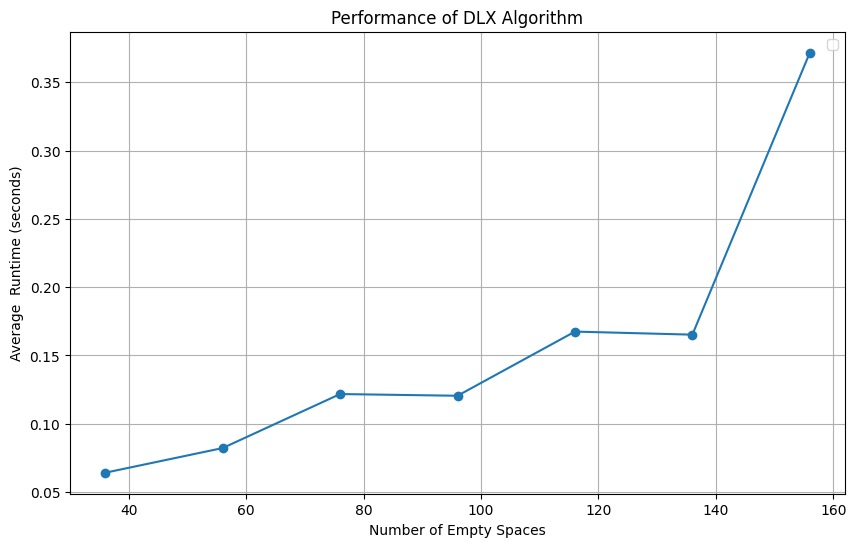

In [88]:
plt.figure(figsize=(10, 6))
# for k in results.keys():
#     plt.plot(k_removed, min(results[k]), label=f'{k} Empty Spaces', marker='o')
plt.plot(256-np.array(numClues), averageTimes, marker='o')
plt.xlabel('Number of Empty Spaces')
plt.ylabel('Average  Runtime (seconds)')
plt.title('Performance of DLX Algorithm')
plt.legend()
plt.grid()
plt.savefig("DLXPlot.png")
plt.show()